In [88]:
! pip install pandas numpy scikit-learn seaborn catboost phik imblearn lightgbm optuna

In [89]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier, Pool
from sklearn.mixture import GaussianMixture
import optuna
from plots import *
from helper import *
import random

In [90]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

In [91]:
df = pd.read_csv('creditcard.csv')

X, y = divide_data(df, 'Class')

In [92]:
X_minority = df[df['Class'] == 1]

X_minority.drop(columns=['Amount', 'Class', 'Time'], inplace=True)

lowest_bic = np.inf
best_gmm = None
best_k = None

for k in range(1, 15):
    gmm = GaussianMixture(n_components=k, random_state=SEED)
    gmm.fit(X_minority)
    bic = gmm.bic(X_minority)
    if bic < lowest_bic:
        lowest_bic = bic
        best_gmm = gmm
        best_k = k

best_k

C:\Users\nemow\AppData\Local\Temp\ipykernel_31544\3316306856.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_minority.drop(columns=['Amount', 'Class', 'Time'], inplace=True)


7

In [93]:
cols_gmm = [c for c in df.columns if c not in ["Amount", "Time"]]

X_minority = df[y == 1][cols_gmm]
gmm = GaussianMixture(n_components=best_k, random_state=42)
gmm.fit(X_minority)

X_new_gmm, _ = gmm.sample(500)
df_new = pd.DataFrame(X_new_gmm, columns=cols_gmm)

for c in ["Amount", "Time"]:
    df_new[c] = X[c].median()

df_new["Class"] = 1

df_augmented = pd.concat([df, df_new], ignore_index=True)

In [94]:
df_augmented.drop(columns=['Time'], inplace=True) # Признак Time содержит количество секунд, прошедших между каждой транзакцией и первой транзакцией в наборе данных.

X_gms, y_gms = divide_data(df_augmented, 'Class')

In [95]:
X_train, X_test, y_train, y_test = train_test_split(
    X_gms, y_gms, 
    test_size=0.2, 
    random_state=SEED,
)

In [96]:
train_pool = Pool(X_train, y_train)
valid_pool = Pool(X_test, y_test)

In [97]:
def objective(trial):
    params = {
        "iterations": 2000,
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 1, 10),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0, 5),
        "border_count": trial.suggest_categorical("border_count", [32, 64, 128]),
        "random_seed": 42,
        "early_stopping_rounds": 100,
        "verbose": False,
        "eval_metric": "F1"
    }
    
    model = CatBoostClassifier(**params)
    model.fit(train_pool, eval_set=valid_pool, use_best_model=True)
    return model.best_score_["validation"]["F1"]

In [98]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2025-09-10 21:27:39,031] A new study created in memory with name: no-name-ff3ba9ee-430a-48d4-891d-3f81b41724f2


[I 2025-09-10 21:27:49,337] Trial 0 finished with value: 0.9206349206349207 and parameters: {'depth': 5, 'learning_rate': 0.28389677346393966, 'l2_leaf_reg': 10, 'bagging_temperature': 0.20620184078633697, 'border_count': 128}. Best is trial 0 with value: 0.9206349206349207.
[I 2025-09-10 21:28:00,896] Trial 1 finished with value: 0.9061662198391421 and parameters: {'depth': 9, 'learning_rate': 0.05487345498450559, 'l2_leaf_reg': 7, 'bagging_temperature': 2.3470729535429466, 'border_count': 64}. Best is trial 0 with value: 0.9206349206349207.
[I 2025-09-10 21:28:06,231] Trial 2 finished with value: 0.9013333333333333 and parameters: {'depth': 7, 'learning_rate': 0.18571903966374928, 'l2_leaf_reg': 10, 'bagging_temperature': 0.14737444420199808, 'border_count': 64}. Best is trial 0 with value: 0.9206349206349207.
[I 2025-09-10 21:28:16,116] Trial 3 finished with value: 0.8700265251989389 and parameters: {'depth': 5, 'learning_rate': 0.01903418138277278, 'l2_leaf_reg': 8, 'bagging_temper

In [99]:
best_params = study.best_params

best_params

{'depth': 4,
 'learning_rate': 0.20859672942066718,
 'l2_leaf_reg': 3,
 'bagging_temperature': 0.433201113739655,
 'border_count': 128}

In [100]:
best_model = CatBoostClassifier(**best_params, iterations=2000, random_seed=42, early_stopping_rounds=1000)
best_model.fit(train_pool, eval_set=valid_pool, use_best_model=True)

0:	learn: 0.2093945	test: 0.2094000	best: 0.2094000 (0)	total: 19.5ms	remaining: 39s
1:	learn: 0.0699314	test: 0.0701798	best: 0.0701798 (1)	total: 42.1ms	remaining: 42.1s
2:	learn: 0.0276836	test: 0.0280865	best: 0.0280865 (2)	total: 60.6ms	remaining: 40.3s
3:	learn: 0.0150740	test: 0.0156084	best: 0.0156084 (3)	total: 76.8ms	remaining: 38.3s
4:	learn: 0.0096612	test: 0.0102458	best: 0.0102458 (4)	total: 96.6ms	remaining: 38.5s
5:	learn: 0.0075796	test: 0.0082167	best: 0.0082167 (5)	total: 116ms	remaining: 38.5s
6:	learn: 0.0064833	test: 0.0071554	best: 0.0071554 (6)	total: 134ms	remaining: 38.1s
7:	learn: 0.0059171	test: 0.0065986	best: 0.0065986 (7)	total: 155ms	remaining: 38.6s
8:	learn: 0.0055870	test: 0.0062803	best: 0.0062803 (8)	total: 177ms	remaining: 39.1s
9:	learn: 0.0049632	test: 0.0056050	best: 0.0056050 (9)	total: 199ms	remaining: 39.7s
10:	learn: 0.0047478	test: 0.0054123	best: 0.0054123 (10)	total: 220ms	remaining: 39.7s
11:	learn: 0.0046067	test: 0.0053585	best: 0.0053

In [105]:
y_pred = best_model.predict(X_test)

from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_proba)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"ROC AUC: {roc_auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1: {f1:.4f}")

ROC AUC: 0.9873
Accuracy: 0.9995
Precision: 0.9887
Recall: 0.8706
F1: 0.9259


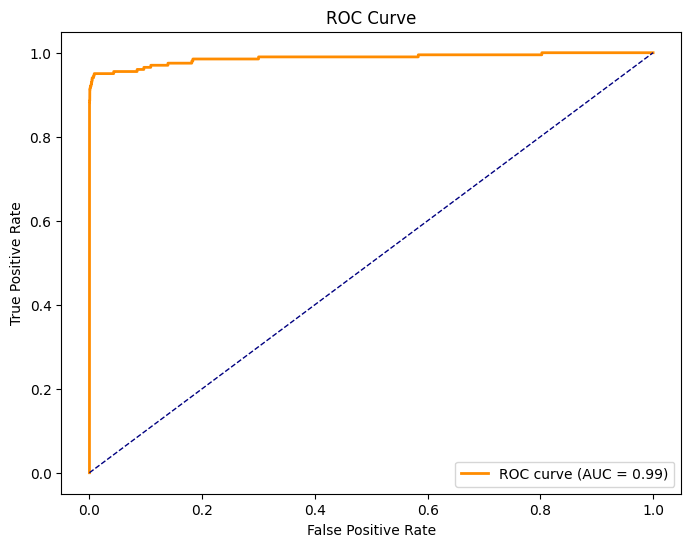

In [102]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

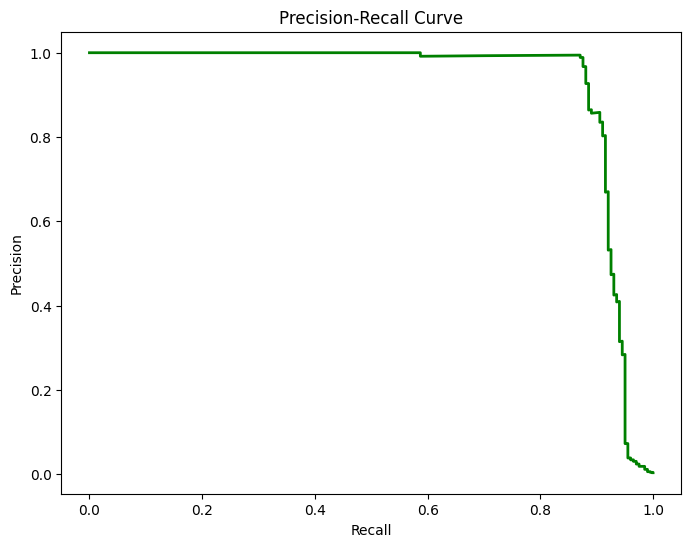

In [103]:
precisions, recalls, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, color='green', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()